# Temperature and Mortality

The research in this notebook is based on a research about the [correlation between temperature and mortality in Scotland](https://academic.oup.com/ije/article/29/2/274/758132). The research claims that there is a higher mortality rate in the winter period compared to the summer period. The research in this notebook aims to find out if such a correlation also exists in the Netherlands.

### Research question

The research question that has been formulated in this research is:

**"Is there a correlation between temperature and mortality in the Netherlands?"**

### Datasets

There are four datasets used in this research:

1. A dataset with monthly average temperatures of 10 weather stations in the Netherlands over the past 70 to 100 years (depending on the station).

2. A dataset with the total number of deceased persons per township in the Netherlands over the past 20 years.

3. A dataset with geometry information of all the townships in the Netherlands.

4. A dataset with the coordinates of the included weather stations.

Instructions on how to retrieve these datasets can be found in ```DATASETS.md``` in the repository. 

In [30]:
import yaml
import re
import matplotlib
import calendar

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from scipy import interpolate
from scipy.signal import savgol_filter
from scipy.stats import linregress

import ipywidgets as widgets
from ipywidgets import interact, Layout, IntSlider
from IPython.display import display, HTML

## 1. Load files and create data frames

In [2]:
with open("config.yaml", "r") as stream:
    config_values = yaml.safe_load(stream)
    temperature_path = config_values['temperature_data_path']
    townships_path = config_values['townships_data_path']
    mortality_path = config_values['mortality_data_path']
    weather_stations_coordinates = config_values['weather_stations_coordinates_path']
    
# Create data frames
temperature_df = pd.read_csv(temperature_path, skiprows=11)
townships_df = pd.read_excel(townships_path)
mortality_df = pd.read_csv(mortality_path, sep=';')
ws_coordinates_df = pd.read_excel(weather_stations_coordinates)

## 2. Inspect data
This sections handles the data inspection of the data frames.

### Temperature

In [3]:
temperature_df.head()

,STN,YYYY,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,YEAR
0,235,1906,40,29,38,68,110,129,162,170,151,123,87,21,94
1,235,1907,26,8,45,73,116,132,137,150,140,115,69,42,88
2,235,1908,0,36,31,55,114,145,160,152,136,101,51,19,83
3,235,1909,17,6,16,71,101,120,139,150,129,112,60,33,80
4,235,1910,39,39,49,72,112,153,144,159,136,103,44,55,92


In [4]:
temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   STN     944 non-null    int64 
 1   YYYY    944 non-null    int64 
 2      JAN  944 non-null    object
 3      FEB  944 non-null    object
 4      MAR  944 non-null    object
 5      APR  944 non-null    object
 6      MAY  944 non-null    object
 7      JUN  944 non-null    object
 8      JUL  944 non-null    object
 9      AUG  944 non-null    int64 
 10     SEP  944 non-null    object
 11     OCT  944 non-null    object
 12     NOV  944 non-null    object
 13     DEC  944 non-null    object
 14    YEAR  944 non-null    object
dtypes: int64(3), object(12)
memory usage: 110.8+ KB


The temperature data frame has a total of 944 entries. There are 15 columns. 12 of these columns are month columns (Jan - Dec). These column names contain leading spaces which should be removed. The remaining three columns are the station number, the year, and the year average. To get the real temperatures, the values need to be divided by 10. What stands out is that, regarding the temperature columns, only August has the correct data type. Also, the column names of the station number and the year could be a bit more descriptive, whereas the name of the year average column (which we don't need) is a little misleading. These issues will be fixed in the data cleaning part.

In [5]:
temperature_df.isna().sum()

STN       0
YYYY      0
   JAN    0
   FEB    0
   MAR    0
   APR    0
   MAY    0
   JUN    0
   JUL    0
   AUG    0
   SEP    0
   OCT    0
   NOV    0
   DEC    0
  YEAR    0
dtype: int64

The temperature data frame is not missing any data.

### Townships

In [6]:
townships_df.head()

,GM_CODE,GM_NAAM,geometry
0,GM0003,Appingedam,<Polygon><outerBoundaryIs><LinearRing><coordin...
1,GM0005,Bedum,<Polygon><outerBoundaryIs><LinearRing><coordin...
2,GM0007,Bellingwedde,<Polygon><outerBoundaryIs><LinearRing><coordin...
3,GM0009,Ten Boer,<Polygon><outerBoundaryIs><LinearRing><coordin...
4,GM0010,Delfzijl,<Polygon><outerBoundaryIs><LinearRing><coordin...


In [7]:
townships_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   GM_CODE   431 non-null    object
 1   GM_NAAM   431 non-null    object
 2   geometry  431 non-null    object
dtypes: object(3)
memory usage: 10.2+ KB


The township data frame exists of 431 entries. There are only 3 columns: the township code (which matches the codes in the mortality data), the township name and the geometry. The data types of the columns are good as they are. The geometry column contains data to create a polygon. However, in this research we don't need a complete polygon, but we need the center point (lat/lon) of the polygons. Furthermore, the column names could be a bit more descriptive. These issues will be fixed in the data cleaning part.

In [8]:
townships_df.isna().sum()

GM_CODE     0
GM_NAAM     0
geometry    0
dtype: int64

The township data frame is not missing any data.

### Mortality

In [9]:
mortality_df.head()

,ID,RegioS,Perioden,Overledenen_3
0,0,NL01,2002MM01,13469
1,1,NL01,2002MM02,11735
2,2,NL01,2002MM03,13281
3,3,NL01,2002MM04,11968
4,4,NL01,2002MM05,11623


In [10]:
mortality_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167076 entries, 0 to 167075
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ID             167076 non-null  int64 
 1   RegioS         167076 non-null  object
 2   Perioden       167076 non-null  object
 3   Overledenen_3  129332 non-null  object
dtypes: int64(1), object(3)
memory usage: 5.1+ MB


The mortality data frame exists of 167076 entries. There are 4 columns: an ID, a region code, a period and the number of deceased people. The ID column should be set as actual ID of the data frame. The values in the region code column can start with the following prefixes: NL (whole Netherlands), LD (landsdeel: country part), CR (COROP area's), PV (province) and GM (gemeente: township). For this research we only need the records with a GM-code. The period column contains a combination of a year and a month number. This column should be separated in two columns: year and month. Furthermore, the data type of the deceased column should be changed to the right data type. Lastly, the column names of this data frame could be a bit more descriptive. These issues will be fixed in the data cleaning part.

In [11]:
mortality_df.isna().sum()

ID                   0
RegioS               0
Perioden             0
Overledenen_3    37744
dtype: int64

It appears that there are 37744 entries that are missing the number of deceased people. For this research the choice has been made to leave out the townships with missing data, to get the most reliable results.

### Weather stations coordinates

In [12]:
ws_coordinates_df

,Station,Latitude,Longitude
0,235,52.927569,4.777465
1,270,53.222570,5.768726
2,280,53.125899,6.584522
3,290,52.273230,6.881168
4,240,52.314998,4.766546
5,260,52.103508,5.176900
6,344,51.924790,4.473661
7,310,51.452907,3.567217
8,370,51.501198,5.474265
9,380,50.905617,5.761880


In [13]:
ws_coordinates_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Station    10 non-null     int64  
 1   Latitude   10 non-null     float64
 2   Longitude  10 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 368.0 bytes


The weather stations coordinates data frame contains the coordinates (lat/lon) of the 10 weather stations that are included in this research. There is no need to clean/modify this data frame.

## 3. Clean data
This section handles the cleaning of the data sets, as described in the data inspection part.

### Temperature

In [14]:
# Remove leading spaces in column names
temperature_df.columns = temperature_df.columns.str.strip()

# Drop YEAR column (year average that we don't need)
temperature_df.drop('YEAR', axis=1, inplace=True)

# Rename station and year column
temperature_df.rename(columns={'STN': 'Station', 'YYYY': 'Year'}, inplace=True)

# Select only the years from 2002
temperature_df = temperature_df.loc[temperature_df['Year'] >= 2002]

# Change data type of month columns to int
temperature_df.loc[:, 'JAN':'DEC'] = temperature_df.loc[:, 'JAN':'DEC'].astype('int64')

# Correct the temperatures by dividing them by 10
temperature_df.loc[:, 'JAN':'DEC'] = temperature_df.loc[:, 'JAN':'DEC'].div(10)

### Townships

In [15]:
def calculate_centroid(coordinates):
    '''Function that takes a set of coordinates of a polygon and calculates the center point'''
    only_numbers = [re.sub(r'[^0-9.]', '', coord) for coord in coordinates][0:-1]
    y = [float(only_numbers[i]) for i in range(0, len(only_numbers), 2)]
    x = [float(only_numbers[i]) for i in range(1, len(only_numbers), 2)]
    l = len(x)
    return sum(x) / l, sum(y) / l

In [16]:
# Rename columns
townships_df.rename(columns={'GM_CODE': 'Code', 'GM_NAAM': 'Name'}, inplace=True)

# Calculate center point of the polygon
townships_df['geometry'] = townships_df['geometry'].astype(str).str.extract(r"<coordinates>(.*)</coordinates>")
townships_df['geometry'] = townships_df['geometry'].str.replace('0.0 ', '', regex=True)
townships_df['geometry'] = townships_df['geometry'].str.replace('0.0', '', regex=True)
townships_df['geometry'] = townships_df['geometry'].str.split(',').apply(calculate_centroid)
townships_df[['Latitude', 'Longitude']] = pd.DataFrame(townships_df['geometry'].tolist(), index=townships_df.index)

# Drop geometry column, since it's not needed anymore
townships_df.drop('geometry', axis=1, inplace=True)

### Mortality

In [17]:
# Set ID column as index
mortality_df.set_index("ID", inplace = True)

# Drop all the entries with a period containing 'JJ'. These are year totals and are not used
mortality_df = mortality_df[mortality_df['Perioden'].str.contains('JJ') == False]

# Split period column into year and month column and drop old period column
mortality_df[['Year','Month']] = mortality_df['Perioden'].str.split('MM',expand=True)
mortality_df.drop('Perioden', axis=1, inplace=True)

# Convert month number to abbreviation. E.g. 8 = AUG
mortality_df['Month'] = mortality_df['Month'].apply(lambda x: calendar.month_abbr[int(x)].upper())

# Rename columns
mortality_df.rename(columns={'RegioS': 'Code', 'Overledenen_3': 'Deceased'}, inplace=True)

# Filter township records (codes starts with GM)
mortality_df = mortality_df.loc[mortality_df['Code'].str[:2] == 'GM']

# Remove all entries of townships that are missing data
total_townships = mortality_df['Code'].nunique()
townships_missing_data = mortality_df.loc[mortality_df['Deceased'].isna()]['Code'].unique()
mortality_df.drop(mortality_df[mortality_df['Code'].isin(townships_missing_data)].index, inplace=True)

# Correct data type of deceased and year column
mortality_df[['Deceased', 'Year']] = mortality_df[['Deceased', 'Year']].apply(pd.to_numeric)

In [18]:
mortality_df.head()

,Code,Deceased,Year,Month
ID,,,,
15561,GM1680,21,2002,JAN
15562,GM1680,16,2002,FEB
15563,GM1680,23,2002,MAR
15564,GM1680,13,2002,APR
15565,GM1680,20,2002,MAY


In [19]:
print(f'From the total of {total_townships} townships are {len(townships_missing_data)} missing deceased data. This leaves a total of {total_townships - len(townships_missing_data)} townships that are included in this  research.')

From the total of 555 townships are 267 missing deceased data. This leaves a total of 288 townships that are included in this  research.


## 4. Merge dataframes

In [20]:
# Merge the mortality and townships data frames
mortality_township_df = pd.merge(mortality_df, townships_df, how='inner', on='Code')

mortality_township_df.head()

,Code,Deceased,Year,Month,Name,Latitude,Longitude
0,GM1680,21,2002,JAN,Aa en Hunze,53.043303,6.716957
1,GM1680,16,2002,FEB,Aa en Hunze,53.043303,6.716957
2,GM1680,23,2002,MAR,Aa en Hunze,53.043303,6.716957
3,GM1680,13,2002,APR,Aa en Hunze,53.043303,6.716957
4,GM1680,20,2002,MAY,Aa en Hunze,53.043303,6.716957


In [21]:
# Merge temperature data frame with weather station coordinates
temperature_coordinate_df = pd.merge(temperature_df, ws_coordinates_df, how='inner', on='Station')

temperature_coordinate_df.head()

,Station,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,Latitude,Longitude
0,235,2002,4.8,6.9,7.1,9.2,12.7,15.9,17.0,19.1,15.9,10.0,8.1,2.3,52.927569,4.777465
1,235,2003,3.4,2.1,6.7,9.4,12.7,17.0,18.4,19.1,15.3,9.0,8.2,5.3,52.927569,4.777465
2,235,2004,4.3,4.8,5.8,10.1,11.6,14.9,16.6,18.7,15.7,11.8,7.8,5.0,52.927569,4.777465
3,235,2005,5.9,3.1,5.6,9.4,11.5,15.4,16.8,16.2,16.3,13.7,8.5,5.3,52.927569,4.777465
4,235,2006,2.0,3.2,3.4,7.8,13.5,15.5,20.9,17.1,18.2,14.2,10.3,7.7,52.927569,4.777465


## 5. Analyse data

In [22]:
# Create a data frame with unique name/lat/lon combinations of all townships
# This data frame is used to vizualize the townships on a map
township_coordinates = mortality_township_df[['Name', 'Latitude','Longitude']].drop_duplicates()
township_coordinates.head()

,Name,Latitude,Longitude
0,Aa en Hunze,53.043303,6.716957
252,Aalsmeer,52.261760,4.756649
504,Aalten,51.920724,6.562381
756,Achtkarspelen,53.221181,6.172388
1008,Alblasserdam,51.868058,4.655749


#### Township and weather station overview
The map below provides an overview of all the townships and weather stations that are included in this research.

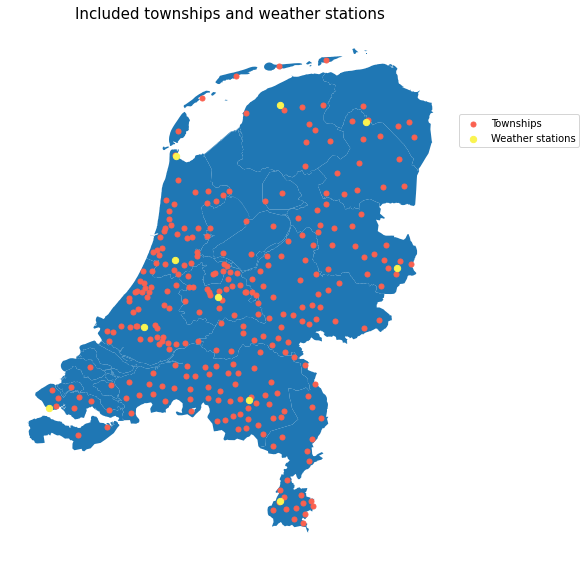

In [23]:
# Import and draw Netherlands shape
shape=gpd.read_file('geodata/')
fig, ax = plt.subplots(1, figsize=(8, 10))
ax.set_title('Included townships and weather stations', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.axis('off')
shape.plot(ax=ax)

# Add points for township coordinates
township_coordinates.plot.scatter(x='Longitude', y='Latitude', color='#fa6150', s=25, ax=ax, label='Townships')

# Add points for weather stations coordinates
ws_coordinates_df.plot.scatter(x='Longitude', y='Latitude', color='#faf450', s=40, ax=ax, label='Weather stations')

# Place legend next to plot
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))

#### Interactive geoplots

In [24]:
def find_nearest(linspace, value):
    '''Function that returns the index of the place in the linspace that is closest to the specified lat or lon value'''
    index = abs(linspace - value).argmin()
    return index


def interpolate_data(matrix, method='linear'):
    '''
    Function that takes a matrix and an interpolation method as input and fills all the 
    nans in the matrix with the specified interpolation method.
    Based on the following Stackoverflow answer: https://stackoverflow.com/a/39596856
    '''
    x = np.arange(0, matrix.shape[1])
    y = np.arange(0, matrix.shape[0])
    array = np.ma.masked_invalid(matrix)

    xx, yy = np.meshgrid(x, y)
    x1 = xx[~array.mask]
    y1 = yy[~array.mask]
    newarr = array[~array.mask]

    return interpolate.griddata((x1, y1), newarr.ravel(), (xx, yy), method=method)


def interpolate_temperature(matrix):
    '''Function that takes a matrix of temperature data and returns an interpolated matrix'''
    # First apply linear interpolation to the data
    linear_interpolated = interpolate_data(matrix, method='linear')
        
    # Apply nearest neighbour interpolation to interpolate the data that falls outside the weather stations polygons
    nearest_interpolated = interpolate_data(linear_interpolated, method='nearest')

    return nearest_interpolated


def select_temperature_data(year, month):
    '''Function that selects the temperature data based on the passed year and month'''
    # Create 100x100 matrix filled with nan
    temperatures = np.full((100, 100), np.nan)
    
    for index, row in ws_coordinates_df.iterrows():
        lon = row['Longitude']
        lat = row['Latitude']
        closest_lon = find_nearest(x, lon)
        closest_lat = find_nearest(y, lat)
        station = row['Station']

        temperature = temperature_coordinate_df.loc[
            (temperature_coordinate_df['Station'] == int(station)) &
            (temperature_coordinate_df['Year'] == year)
        ][month].item()

        temperatures[closest_lat][closest_lon] = temperature
    
    return temperatures


def get_temperatures(year, month):
    '''Function that gets and returns the new temperature data'''
    temperatures = select_temperature_data(year, month)
    interpolated_temperatures = interpolate_temperature(temperatures)
    
    return interpolated_temperatures.round(decimals=1)


def update_temperature_plot(month, month_label, year):
    '''Function that updates the temperature plot'''
    global ax, colorbar, white_overlay
    
    # Clear ax
    ax[0].clear()
    
    # Update title
    ax[0].set_title(f'Average temperature (°C) {month_label} {year}')
    
    # Get data and redraw plot
    ax[0].axis('off')
    new_temperatures = get_temperatures(year, month)
    c = ax[0].pcolormesh(x, y, new_temperatures, cmap=color_map, shading='gouraud')
    new_binary = matplotlib.colors.ListedColormap(np.array([[1., 1., 1., 1.], [0., 0., 0., 0.]]))
    ax[0].pcolormesh(x, y, white_overlay, cmap=new_binary)
    colorbar.mappable.set_clim(new_temperatures.min(), new_temperatures.max())
    shape.plot(ax=ax[0], edgecolor='black', facecolor='none', linewidth=1.2)
    
    
def update_deceased_plot(month_label, month_number, year):
    '''Function that updates the deceased plot'''
    global ax
    
    # Clear ax
    ax[1].clear()
    
    # Update title
    ax[1].set_title(f'Deceased {month_label} {year}')
    
    # Get data and redraw plot
    ax[1].axis('off')
    shape.plot(ax=ax[1])
    new_deceased, scatter_sizes = get_deceased(year, month_number)
    new_deceased.plot.scatter(x='Longitude', y='Latitude', color='red', s=scatter_sizes, alpha=0.5, ax=ax[1], label='Townships')
    

def get_scatter_size(deceased):
    '''Function that calculates the size of the scatter points based on the percentual difference
    with the mean mortality of the township 
    '''
    standard_sizes = [25 for i in range(len(deceased))]
    mortality_means = mortality_township_df.groupby(['Code'])['Deceased'].mean().tolist()
    deceased = deceased['Deceased'].tolist()
    delta_deceased = [((j - i) / i) * 100 for i, j in zip(mortality_means, deceased)]
    percentage = [i + 100 if i >= 0 else 100 + i for i in delta_deceased]
    sizes = [standard_sizes[i] / 100 * percentage[i] for i in range(len(percentage))]
    return sizes


def get_deceased(year, month):
    '''Function that gets and returns the deceased data'''
    deceased = mortality_township_df.loc[
        (mortality_township_df['Year'] == year) &
        (mortality_township_df['Month'] == month)
    ].sort_values('Code')
    
    sizes = get_scatter_size(deceased)
    return deceased, sizes


def update_plots(Period=5):
    '''Function that updates the plots when the slider value changed'''
    # Calculate year
    year = (Period // 12) + 2002
    
    # Calculate month
    month_number = Period % 12
    if month_number == 0:
        month_number = 12
        
    month = calendar.month_abbr[month_number].upper()
    month_label = calendar.month_name[month_number]
    
    update_temperature_plot(month, month_label, year)
    update_deceased_plot(month_label, month, year)
    

def point_in_nl(point):
    '''Function that checks if a point (lat/lon) is in the Netherlands contours'''
    for polygon in shape.geometry:
        if polygon.contains(point):
            
            return True
    return False

<IPython.core.display.Javascript object>


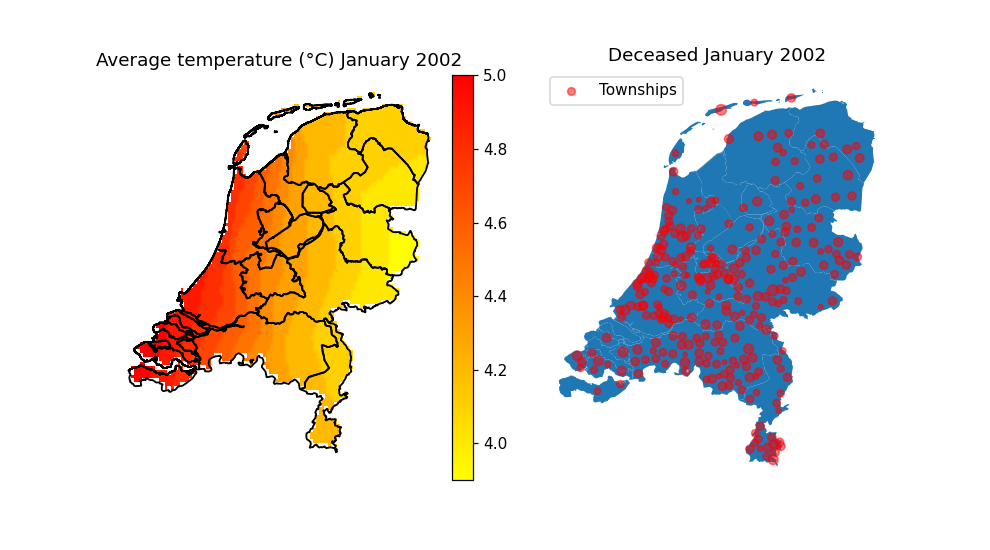

interactive(children=(IntSlider(value=1, description='Period', layout=Layout(width='900px'), max=251, min=1), …

In [25]:
# Insert some HTML to hide the ugly toolbars that %matplotlib notebook adds
display(HTML('''<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>'''))

# Change matplotlib backend for interactive plots
%matplotlib notebook

# Create figure with two axes
fig, ax = plt.subplots(1, 2, figsize=(9, 5))

# Create a numpy meshgrid
a = np.linspace(3.3, 7.3, 100)
b = np.linspace(50.5, 53.7, 100)
x, y = np.meshgrid(a, b, sparse=True)  

# Get temperature data and draw plot
new_temperatures = get_temperatures(2002, 'JAN')
color_map = matplotlib.cm.autumn_r
# d = ax[0].pcolormesh(x, y, z, cmap=new_binary, shading='gouraud')
c = ax[0].pcolormesh(x, y, new_temperatures, cmap=color_map, shading='gouraud')
colorbar = fig.colorbar(c, ax=ax[0],  fraction=0.058)
shape.plot(ax=ax[0], edgecolor='black', facecolor='none')

# Create a white overlay to only show interpolated data in the Netherlands contours
white_overlay = np.zeros((100, 100))
for i in range(len(x[0])):
    for j in range(len(y)):
        point = gpd.points_from_xy(x=[x[0][i]], y=[y[j][0]])
        if point_in_nl(point):
            white_overlay[j][i] = 1


# Get deceased data and draw plot
shape.plot(ax=ax[1])
new_deceased, scatter_sizes = get_deceased(2002, 'JAN')
new_deceased.plot.scatter(x='Longitude', y='Latitude', color='red', s=scatter_sizes, alpha=0.5, ax=ax[1], label='Townships')

interact(update_plots, Period=IntSlider(1, 1, 251, 1, layout=Layout(width='900px')));

#### Interpolation explained
To interpolate the temperature data, first linear interpolation is applied to the spatial area between the weather stations. This is shown in the left picture below. Because linear interpolation is not possible outside of this area, nearest neighbour interpolation is applied to interpolate the spatial area outside the weather station polygon. This can be seen in the middle picture below. Finally, Gouraud shading is applied and the interpolated data is limited to the contours of the Netherlands. This is show in the right picture below.

![title](images/interpolation.png)

Based on the graphs above, it is difficult to say whether there is a correlation between temperature and mortality. It is quite hard to see local differences. However, when using the slider to go through the years, it seems that relatively many people die in the winter season (Dec. - Jan.) compared to the other seasons. This may implie that more people die when the temperature is low. The table below can be used to verify this.

#### Mortality and average temperature per month
The table below provides an overview of the total number of deceased people and the average temperature per month, over the years 2002-2022.

In [26]:
month_list = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

# Set specific order for the months
mortality_df['Month'] = pd.Categorical(mortality_df['Month'], month_list)

# Sum the number of deceased people, grouped by month
mortality_per_month = mortality_df.groupby('Month')['Deceased'].sum().to_frame()

# Create empty data frame with 'Month' and 'Average temperature' columns
avg_temperature_per_month = pd.DataFrame(columns=['Month', 'Average temperature'])

# For every month, add an entry to the newly created dataframe with the average temperature for that month
for month in month_list:
    avg_temperature_per_month.loc[len(avg_temperature_per_month)] = [month, round(temperature_df[month].mean(), 2)]

# Set month column as index
avg_temperature_per_month.set_index('Month', inplace=True)

# Merge the newly created dataframes above
mortality_temperature_month_df = pd.merge(mortality_per_month, avg_temperature_per_month, how='inner', on='Month')

mortality_temperature_month_df

,Deceased,Average temperature
Month,,
JAN,239073,3.79
FEB,214832,4.01
MAR,232532,6.29
APR,214208,9.78
MAY,205086,13.18
JUN,194136,16.49
JUL,201311,18.28
AUG,197355,18.03
SEP,191792,15.19


In the table above we see that mortality is at its peak in January, and at its lowest in September. In general, we can say that the mortality rate is higher when temperatures are lower. To verify this, we can use the line graph below.

#### Interactive line plot
The plot below compares the total deceased people in the Netherlands to the average temperature in the Netherlands.

In [27]:
def update_line_plot(Period=0):
    '''Function that updates the line plot on slider change'''
    global temperature_ax, deceased_ax, line_fig
    
    # Clear ax
    temperature_ax.clear()
    deceased_ax.clear()
        
    # Redraw plot
    deceased_ax.set_title('Average temperature Netherlands °C  vs. total deceased (2002 - 2022)')
    temperature_line, = temperature_ax.plot(x_range[Period:Period + 12], y_temperature_smooth[Period:Period+12], color='blue', label='Temperature')
    deceased_line, = deceased_ax.plot(x_range[Period:Period + 12], y_deceased_smooth[Period:Period+12], color='red', label='Deceased')
    
    # Configure x axis
    deceased_ax.set_xticks(x_range[Period:Period + 12])
    deceased_ax.set_xticklabels(month_ticks_list[Period:Period + 12])
    temperature_ax.set_xlabel('Month')
    
    # Configure y axis
    temperature_ax.set_ylabel('Temperature °C')
    deceased_ax.set_ylabel('Total deceased')
    
    deceased_ax.legend([temperature_line, deceased_line],['Temperature', 'Deceased'], loc='upper center')

<IPython.core.display.Javascript object>


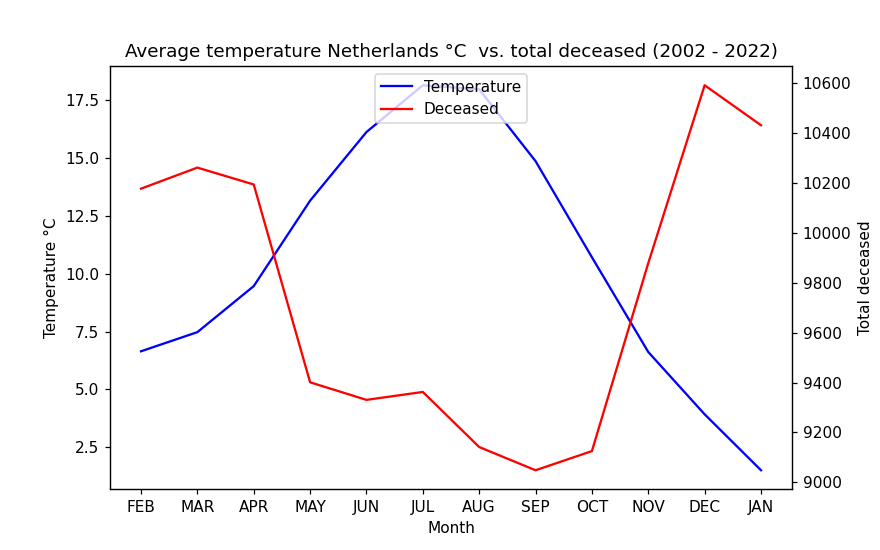

interactive(children=(IntSlider(value=1, description='Period', layout=Layout(width='850px'), max=240), Output(…

In [28]:
# Create a list with month ticks
month_ticks_list = month_list * 21

# Create range for x axis
x_range = [i for i in range(21 * 12)]

# Create list of temperature data
avg_temperature_df = temperature_df.groupby(['Year'])[month_list].mean()
y_temperature = []
for i, row in avg_temperature_df.iterrows():
    for month in month_list:
        y_temperature.append(row[month])
        
# Smooth temperature data     
y_temperature_smooth = savgol_filter(y_temperature, 5, 3)

# Create list of deceased data
mortality_township_df['Month'] = pd.Categorical(mortality_township_df['Month'], month_list)
sum_mortality_df = mortality_township_df.groupby(['Year', 'Month'])['Deceased'].sum()
y_deceased = []
for year in range(2002, 2023):
    for i in sum_mortality_df[year]:
        y_deceased.append(i)
        
# Smooth deceased data     
y_deceased_smooth = savgol_filter(y_deceased, 5, 3)

# Create plot
line_fig, temperature_ax = plt.subplots(1, 1, figsize=(8, 5))
deceased_ax = temperature_ax.twinx()
interact(update_line_plot, Period=IntSlider(1, 0, len(x_range)-12, 1, layout=Layout(width='850px')));

The graph shows pretty clearly that in general, when temperatures drop, the number of deceased people increases. When the temperatures rise, again, the number of deceased people decreases. This indicates a correlation between temperature and mortality.

## 6. Statistics
To determine whether this assumption is correct, we plot the linear regression line and asses the P-value and Pearson's correlation coefficient that are calculated with the linregress function of scipy stats.

<IPython.core.display.Javascript object>


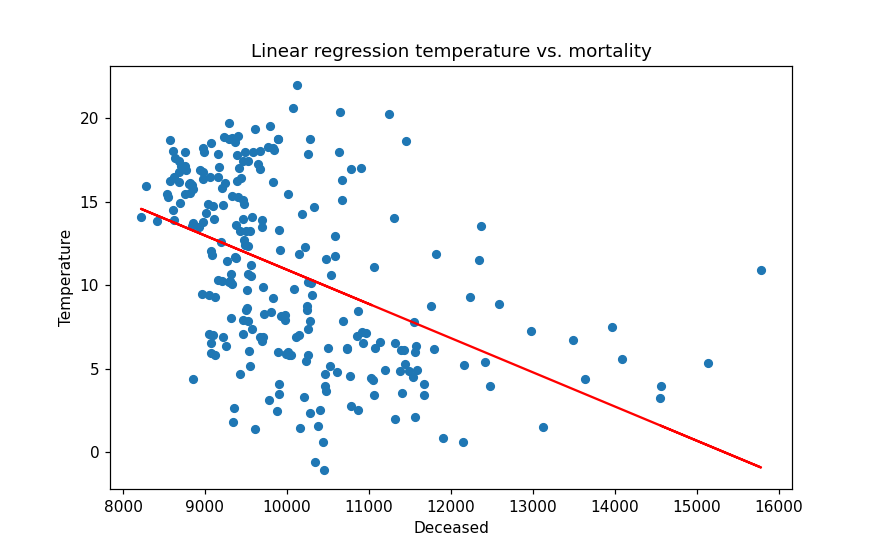

P-value: 3.1500153992007552e-15
Pearson's correlation coefficient: -0.46962917018489597


In [29]:
# Apply linear regression
slope, intercept, r_value, p_value, std_err = linregress(y_deceased, y_temperature)

stats_fig, stats_ax = plt.subplots(1, 1, figsize=(8, 5))
stats_ax.scatter(y_deceased, y_temperature,  s=25, label='Weather stations')
stats_ax.plot(y_deceased, intercept + slope*np.array(y_deceased), 'r', label='fitted line')
stats_ax.set_title('Linear regression temperature vs. mortality')
stats_ax.set_xlabel('Deceased')
stats_ax.set_ylabel('Temperature')

print(f'P-value: {p_value}')
print(f"Pearson's correlation coefficient: {r_value}")

Based on the P-value, which is a lot smaller then 0.05, it can be said that the correlation is statistically significant. 

Based on Pearson's correlation coefficient, it can be said that there is a medium, negative correlation.

### Conclusion
Based on this research, it can be concluded that there exists a medium, negative correlation between temperature and mortality in the Netherlands that is statistically significant. However, it must be said that in this research only 10 weather stations were included. This means that the temperature of some large spatial areas needed to be interpolated, which can cause inaccuracy in the results.